In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time


In [2]:
#download MNIST data
import gzip
import sys
import struct
import urllib.request
import numpy as np

def read_image(fi):
    magic, n, rows, columns = struct.unpack(">IIII", fi.read(16))
    assert magic == 0x00000803
    assert rows == 28
    assert columns == 28
    rawbuffer = fi.read()
    assert len(rawbuffer) == n * rows * columns
    rawdata = np.frombuffer(rawbuffer, dtype='>u1', count=n*rows*columns)
    return rawdata.reshape(n, rows, columns).astype(np.float32) / 255.0

def read_label(fi):
    magic, n = struct.unpack(">II", fi.read(8))
    assert magic == 0x00000801
    rawbuffer = fi.read()
    assert len(rawbuffer) == n
    return np.frombuffer(rawbuffer, dtype='>u1', count=n)

def openurl_gzip(url):
    request = urllib.request.Request(
        url,
        headers={
            "Accept-Encoding": "gzip",
            "User-Agent": "Mozilla/5.0 (X11; U; Linux i686) Gecko/20071127 Firefox/2.0.0.11", 
        })
    response = urllib.request.urlopen(request)
    return gzip.GzipFile(fileobj=response, mode='rb')

if __name__ == '__main__':
    np.savez_compressed(
        'mnist',
        train_x=read_image(openurl_gzip('http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz')),
        train_y=read_label(openurl_gzip('http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz')),
        test_x=read_image(openurl_gzip('http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz')),
        test_y=read_label(openurl_gzip('http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz'))
    )
     

In [3]:
import numpy as np
data = np.load('mnist.npz')

print(data['train_x'].shape, data['train_x'].dtype)
print(data['train_y'].shape, data['train_y'].dtype)
print(data['test_x'].shape, data['test_x'].dtype)
print(data['test_y'].shape, data['test_y'].dtype)

(60000, 28, 28) float32
(60000,) uint8
(10000, 28, 28) float32
(10000,) uint8


0


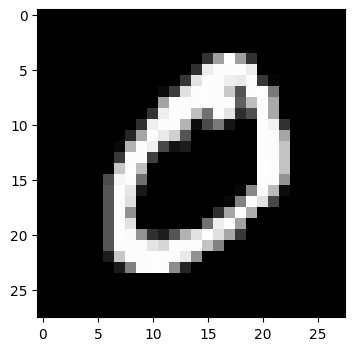

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Index number of an instance (change this to view another instance).
i = 1

data = np.load('mnist.npz')
image = data['train_x'][i]
label = data['train_y'][i]

print(label)
f, ax = plt.subplots(figsize=(4, 4))
ax.imshow(image, cmap='gray')
plt.show()
     

In [5]:
import numpy as np

def image_to_vector(X):
    X = np.reshape(X, (len(X), -1))         # Flatten: (N x 28 x 28) -> (N x 784)
    return X

data = np.load('mnist.npz')
Xtrain = image_to_vector(data['train_x'])   # (60000 x 784)
Ytrain = data['train_y']                    # (60000)
Xtest = image_to_vector(data['test_x'])     # (10000 x 784)
Ytest = data['test_y']                      # (10000)

In [6]:
import TensorFrost as tf
tf.initialize(tf.opengl)

TensorFrost module loaded in debug mode! Expect slow performance.


In [23]:
learning_rate = 5.0

def leaky_relu(X):
	return tf.select(X > 0.0, X, 0.01 * X)

def softmax(X):
    exp = tf.exp(X)
    norm = tf.sum(exp, axis = 1)
    return exp / tf.reshape(norm, [norm.shape[0], 1])

def forward(W, X, b):
    L1 = leaky_relu(tf.matmul(X, W) + b)
    return L1

def loss(Y, Yhat):
    Y *= 1.0 #tensor view bug
    return tf.sum(tf.sum((Y - Yhat) ** 2.0)) / tf.float(Y.shape[1] * Y.shape[0])

def backward(W, X, b, Y, Yhat):
    dL2 = 2.0 * (Yhat - Y) / tf.float(Yhat.shape[1] * Yhat.shape[0])
    dL1 = dL2 * tf.select(Yhat > 0.0, 1.0, 0.01)
    dW = tf.matmul(tf.transpose(X), dL1)
    db = tf.sum(dL1, axis = 0)
    return dL2, dL1, dW, db

def update(W, b,  dW, db, lr):
    W -= lr * dW
    b -= lr * db
    return W, b

def step():
    W = tf.input([-1, -1], tf.float32)
    In, Out = W.shape
    b = tf.input([Out], tf.float32)

    X = tf.input([-1, In], tf.float32)
    Y = tf.input([-1, Out], tf.float32)
    
    info = tf.input([2], tf.int32)
    offset = info[0]
    batch_size = info[1]

    #TODO: implement slicing instead of this crap
    i, j = tf.indices([batch_size, In])
    Xbatch = X[i + offset, j]
    i, j = tf.indices([batch_size, Out])
    Ybatch = Y[i + offset, j]

    Yhat = forward(W, Xbatch, b)
    L = loss(Ybatch, Yhat)
    dL2, dL1, dW, db = backward(W, Xbatch, b, Ybatch, Yhat)
    W, b, = update(W, b, dW, db, learning_rate)

    return [L, W, b, dW, db, dL2, dL1]

train_step = tf.compile(step)

def backwards():
    In = 784
    Out = 10
    Xbatch = tf.input([-1, In], tf.float32)
    b_size = Xbatch.shape[0]
    Ybatch = tf.input([b_size, Out], tf.float32)
    Yhat = tf.input([b_size, Out], tf.float32)

    dL2, dL1, dW, db = backward(Xbatch, Xbatch, Ybatch, Ybatch, Yhat)
    #W, b, = update(W, b, dW, db, 0.000)

    return [dL2, dL1, dW, db]

#backw = tf.compile(backwards)

def forward_numpy(W, X, b):
    L1 = np.maximum(0.01 * (np.dot(X, W) + b), np.dot(X, W) + b)
    return L1

def loss_numpy(Y, Yhat):
    return np.sum((Y - Yhat) ** 2.0) / (Y.shape[1] * Y.shape[0])

def backward_numpy(W, X, b, Y, Yhat):
    dL2 = 2.0 * (Yhat - Y)
    dL1 = dL2 * (Yhat > 0.0) + 0.01 * dL2 * (Yhat <= 0.0)
    dW = np.dot(X.T, dL1)
    db = np.sum(dL1, axis = 0)
    return dL2, dL1, dW, db

def step_numpy(W, b, X, Y, offset, batch_size):
    Xbatch = X[offset:offset + batch_size]
    Ybatch = Y[offset:offset + batch_size]
    Yhat = forward_numpy(W, Xbatch, b)
    L = loss_numpy(Ybatch, Yhat)
    dL2, dL1, dW, db = backward_numpy(W, Xbatch, b, Ybatch, Yhat)
    W, b, = update(W, b, dW, db, learning_rate)
    return L, W, b, dW, db, dL2, dL1

def compare_tf_np(W, b, X, Y, offset, batch_size):
    Xbatch = X[offset:offset + batch_size]
    Ybatch = Y[offset:offset + batch_size]
    Yhat = forward_numpy(W, Xbatch, b)
    L = loss_numpy(Ybatch, Yhat)
    dL2, dL1, dW, db = backward_numpy(W, Xbatch, b, Ybatch, Yhat)
    dL2tf, dL1tf, dWtf, dbtf = backw(tf.tensor(Xbatch), tf.tensor(Ybatch), tf.tensor(Yhat))
    print(np.linalg.norm(dL2 - dL2tf.numpy), np.linalg.norm(dL1 - dL1tf.numpy), np.linalg.norm(dW - dWtf.numpy), np.linalg.norm(db - dbtf.numpy))
    W, b, = update(W, b, dW, db, 0.001)
    return L, W, b, dW, db, dL2, dL1

step:
  Kernel count: 9
  Intermediate buffers: 3
  Host readbacks: 1
  Host writes: 0
  Lines of generated code: 445
  IR Compile time: 108.717598 ms
  Compiler time: 1345.138916 ms



In [8]:
def forward_step():
    W = tf.input([-1, -1], tf.float32)
    In, Out = W.shape
    b = tf.input([Out], tf.float32)
    X = tf.input([-1, In], tf.float32)
    Yhat = forward(W, X, b)
    return [Yhat]

fwd_step = tf.compile(forward_step)

forward_step:
  Kernel count: 1
  Intermediate buffers: 0
  Host readbacks: 0
  Host writes: 0
  Lines of generated code: 415
  IR Compile time: 19.372200 ms
  Compiler time: 1287.133057 ms



In [9]:
Xsamples = Xtrain
Ysamples = np.zeros((Xsamples.shape[0], 10))
Ysamples[np.arange(Xsamples.shape[0]), Ytrain] = 1.0

print (Xsamples.shape)
print (Ysamples.shape)

W = np.random.randn(28 * 28, 10).astype(np.float32) # (784 x 10)
b = np.random.randn(10).astype(np.float32) # (10)

(60000, 784)
(60000, 10)


In [24]:
Wtf = tf.tensor(W)
btf = tf.tensor(b)
Xtf = tf.tensor(Xsamples)
Ytf = tf.tensor(Ysamples)

In [25]:
batch_size = 1024
epochs = 300
iterations = Xsamples.shape[0] // batch_size

loss_curve = []

for i in range(epochs):
    avg_loss_tf = 0.0
    avg_loss = 0.0
    for j in range(iterations):
        offset = j * batch_size
        info = np.array([offset, batch_size])
        info_tf = tf.tensor(info)
        L, Wtf, btf, dWtf, dbtf, dL2tf, dL1tf = train_step(Wtf, btf, Xtf, Ytf, info_tf)
        avg_loss_tf += L.numpy
        
        #print("Tf loss", L.numpy)
        #L, W, b, dW, db, dL2, dL1 = step_numpy(W, b, Xsamples, Ysamples, offset, batch_size)
        #avg_loss += L
        #print("Numpy loss", L)
        #print(np.linalg.norm(dW - dWtf.numpy), np.linalg.norm(db - dbtf.numpy), np.linalg.norm(dL2 - dL2tf.numpy), np.linalg.norm(dL1 - dL1tf.numpy))
    loss_curve.append(avg_loss_tf / iterations)
    print("Epoch: ", i, " Loss: ", avg_loss / iterations, " Tf Loss: ", avg_loss_tf / iterations)

Epoch:  0  Loss:  0.0  Tf Loss:  [4.4772186]
Epoch:  1  Loss:  0.0  Tf Loss:  [2.3757513]
Epoch:  2  Loss:  0.0  Tf Loss:  [1.5486374]
Epoch:  3  Loss:  0.0  Tf Loss:  [1.0224407]
Epoch:  4  Loss:  0.0  Tf Loss:  [0.68915284]
Epoch:  5  Loss:  0.0  Tf Loss:  [0.47888604]
Epoch:  6  Loss:  0.0  Tf Loss:  [0.34709498]
Epoch:  7  Loss:  0.0  Tf Loss:  [0.26946098]
Epoch:  8  Loss:  0.0  Tf Loss:  [0.22355057]
Epoch:  9  Loss:  0.0  Tf Loss:  [0.1977534]
Epoch:  10  Loss:  0.0  Tf Loss:  [0.18069229]
Epoch:  11  Loss:  0.0  Tf Loss:  [0.16966164]
Epoch:  12  Loss:  0.0  Tf Loss:  [0.16132595]
Epoch:  13  Loss:  0.0  Tf Loss:  [0.15459222]
Epoch:  14  Loss:  0.0  Tf Loss:  [0.14905423]
Epoch:  15  Loss:  0.0  Tf Loss:  [0.14445378]
Epoch:  16  Loss:  0.0  Tf Loss:  [0.14061011]
Epoch:  17  Loss:  0.0  Tf Loss:  [0.13737725]
Epoch:  18  Loss:  0.0  Tf Loss:  [0.13458152]
Epoch:  19  Loss:  0.0  Tf Loss:  [0.13214926]
Epoch:  20  Loss:  0.0  Tf Loss:  [0.1299749]
Epoch:  21  Loss:  0.0  Tf Lo

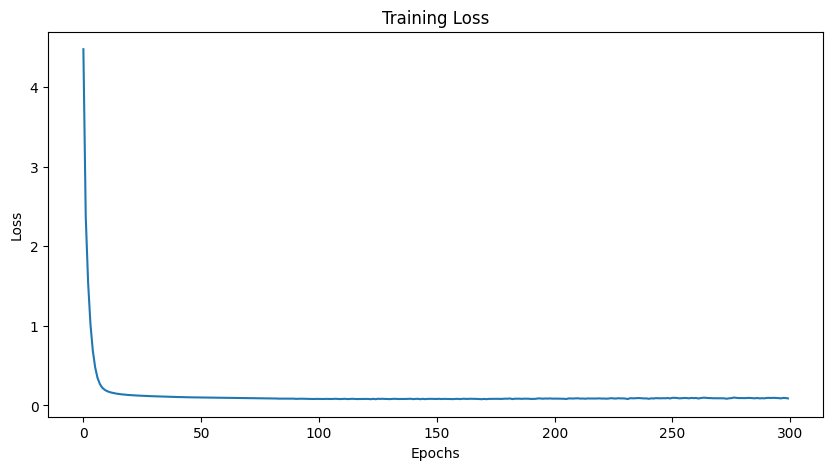

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(loss_curve)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

In [27]:
# Test the model
#Wtf = tf.tensor(W)
#btf = tf.tensor(b)
correct_tf = 0
correct = 0
N = 1000
for i in range(N):
    Yhat, = fwd_step(Wtf, btf, tf.tensor(Xtest[i].reshape(1, -1)))
    #print(Yhat.numpy)
    if np.argmax(Yhat.numpy) == Ytest[i]:
        correct_tf += 1
    #Yhat = forward_numpy(W, Xtest[i].reshape(1, -1), b)
    #print(Yhat)
    #if np.argmax(Yhat) == Ytest[i]:
    #    correct += 1

print("Accuracy: ", correct * 100.0 / N, " %, Tf Accuracy: ", correct_tf * 100.0 / N, " %")

Accuracy:  0.0  %, Tf Accuracy:  56.5  %
